# Прекод

# Сборный проект-4

Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [1]:
pip install -U "transformers>=4.39.0" accelerate pillow tqdm -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импортируем библиотеки

import os
import random
import re
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

# Фиксируем рандом
np.random.seed(42)
tf.random.set_seed(42)

# Пути к данным
TRAIN_IMG_DIR = "/Users/kiradejko/SB5/train_images/"
TEST_IMG_DIR  = "/Users/kiradejko/SB5/test_images/"

# Размерность вектора изображений (ResNet50)
IMG_VEC_SIZE = 2048

2025-11-22 14:02:50.839339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


__Загрузим и просмотрим все входные данные__

In [3]:
train_dataset=pd.read_csv('/Users/kiradejko/SB5/train_dataset.csv')
test_queries = pd.read_csv('/Users/kiradejko/SB5/test_queries.csv', sep='|', index_col=0)
CrowdAnnotations = pd.read_csv('/Users/kiradejko/SB5/CrowdAnnotations.tsv', sep='\t', names= ['image', 'query_id', 'prop_conf', 'col_conf', 'col_not_conf'])
ExpertAnnotations = pd.read_csv('/Users/kiradejko/SB5/ExpertAnnotations.tsv', sep='\t', names= ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3' ])

In [4]:
display(train_dataset.info())
display(train_dataset.head(40))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

image                     query_id  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1   1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2   2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3   2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4   2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5   3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6   3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7   3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8    343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9   3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
10  3741827382_71e93298d0.jpg  2549968784_39bfbe44f9.jpg#2   
11   486712504_36be449055.jpg  2549968784_39bfbe44f9.jpg#2   
12  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
13  1167669558_87a8a467d6.jpg  2718495608_d8533e3ac5.jpg#2   
14  2616643090_4f2d2d1a44.jpg  2718495608_d8533e3ac5.jpg#2   
15  2648165716_02e2e74fd6.jpg  2718495608_d8533e3ac5.jpg#2   
16  2718495608_d8533e3ac5.jpg  2718495608_d8533e3ac5.jpg#2   
17  3244747165_17028936e0.jpg  2718495608_d8533e3ac5.jpg#2   
18  3503689049_63212220be.jpg  2718495608_d8533e3ac5.jpg#2   
19  3506560025_8d0f4f9ac4.jpg  2718495608_d8533e3ac5.jpg#2   
20  3718964174_cb2dc1615e.jpg  2718495608_d8533e3ac5.jpg#2   
21   700884207_d3ec546494.jpg  2718495608_d8533e3ac5.jpg#2   
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   
27  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
28  3208074567_ac44aeb3f3.jpg  3207358897_bfa61fa3c6.jpg#2   
29  3251976937_20625dc2b8.jpg  3207358897_bfa61fa3c6.jpg#2   
30   370713359_7560808550.jpg  3207358897_bfa61fa3c6.jpg#2   
31  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
32  1962729184_6996e128e7.jpg  3286822339_5535af6b93.jpg#2   
33  2101457132_69c950bc45.jpg  3286822339_5535af6b93.jpg#2   
34  2225231022_1632d0a5aa.jpg  3286822339_5535af6b93.jpg#2   
35  3100251515_c68027cc22.jpg  3286822339_5535af6b93.jpg#2   
36   370614351_98b8a166b9.jpg  3286822339_5535af6b93.jpg#2   
37   391579205_c8373b5411.jpg  3286822339_5535af6b93.jpg#2   
38  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2   
39  2311690895_0d6efe11c8.jpg  3360930596_1e75164ce6.jpg#2   

                                           query_text  
0   A young child is wearing blue goggles and sitt...  
1   A young child is wearing blue goggles and sitt...  
2   A young child is wearing blue goggles and sitt...  
3   A young child is wearing blue goggles and sitt...  
4   A young child is wearing blue goggles and sitt...  
5   A young child is wearing blue goggles and sitt...  
6   A young child is wearing blue goggles and sitt...  
7   A young child is wearing blue goggles and sitt...  
8   A young child is wearing blue goggles and sitt...  
9   A young child is wearing blue goggles and sitt...  
10  A young child is wearing blue goggles and sitt...  
11  A young child is wearing blue goggles and sitt...  
12  A girl wearing a yellow shirt and sunglasses s...  
13  A girl wearing a yellow shirt and sunglasses s...  
14  A girl wearing a yellow shirt and sunglasses s...  
15  A girl wearing a yellow shirt and sunglasses s...  
16  A girl wearing a yellow shirt and sunglasses s...  
17  A girl wearing a yellow shirt and sunglasses s...  
18  A girl wearing a yellow shirt and sunglasses s...  
19  A girl wearing a yellow shirt and sunglasses s...  
20  A girl wearing a yellow shirt and sunglasses s...  
21  A girl wearing a yellow shirt and sunglasses s...  
22    A man sleeps under a blanket on a city street .  
23    A man sleeps under a blanket on a city street .  
24    A man sleeps under a blanket on a city street .  
25    A man sleeps under 

In [5]:
display(test_queries.info())
display(test_queries.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   
5  1232148178_4f45cc3284.jpg#0   
6  1232148178_4f45cc3284.jpg#1   
7  1232148178_4f45cc3284.jpg#2   
8  1232148178_4f45cc3284.jpg#3   
9  1232148178_4f45cc3284.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   
5                    A baby girl playing at a park .   
6  A closeup of a child on a playground with adul...   
7  A young boy poses for a picture in front of a ...   
8  A young girl is smiling in front of the camera...   
9  There is a little blond hair girl with a green...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg  
5  1232148178_4f45cc3284.jpg  
6  1232148178_4f45cc3284.jpg  
7  1232148178_4f45cc3284.jpg  
8  1232148178_4f45cc3284.jpg  
9  1232148178_4f45cc3284.jpg

In [6]:
display(CrowdAnnotations.info())
display(CrowdAnnotations.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   prop_conf     47830 non-null  float64
 3   col_conf      47830 non-null  int64  
 4   col_not_conf  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

image                     query_id  prop_conf  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   1.000000   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.000000   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   0.000000   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.000000   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   0.000000   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2   0.000000   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2   0.000000   
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2   0.333333   
8  1056338697_4f7d7ce270.jpg  2307118114_c258e3a47e.jpg#2   0.000000   
9  1056338697_4f7d7ce270.jpg  2309860995_c2e2a0feeb.jpg#2   0.000000   

   col_conf  col_not_conf  
0         3             0  
1         0             3  
2         0             3  
3         0             3  
4         0             3  
5         0             3  
6         0             3  
7         1             2  
8         0             3  
9         0             3

In [7]:
display(ExpertAnnotations.info())
display(ExpertAnnotations.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2         1         1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2         1         1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2         1         1   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2         1         1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2         2         2   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2  
5         1  
6         1  
7         2  
8         1  
9         2

In [8]:
train_images = '/Users/kiradejko/SB5/train_images'
test_images = '/Users/kiradejko/SB5/test_images'

train_image_files = os.listdir(train_images)
test_image_files = os.listdir(test_images)

print(len(train_image_files), "train images")
print(train_image_files[:5])

1000 train images
['2869491449_1041485a6b.jpg', '2924259848_effb4dcb82.jpg', '2300168895_a9b83e16fc.jpg', '3530843182_35af2c821c.jpg', '3439382048_d2e23b2b4c.jpg']


__Данные загружены. Приступим к исследовательскому анализу.__ 

1.1. Поэтапно проведем анализ всех датасетов: 
- train_dataset.csv
- ExpertAnnotations.tsv
- CrowdAnnotations.tsv
- test_queries.csv


1.2. Выполним агрегации и подготовку таргета:

1. Агрегируем оценки экспертов в ExpertAnnotations:
   - оставим одну оченку по принципу голосования большинства.
   - удалим строки, где оценки все разные (например 1, 2, 3).
   - приведем экспертные оценки в диапазон [0, 1]. 

2. Проанализируем CrowdAnnotations:
   - Оставим только значения prop_conf, так как они уже приведены в нужный нам диапазон [0, 1].

4. Объединим ExpertAnnotations и CrowdAnnotations. 

__1.1.Проведем исследовательский анализ всех датасетов:__

Число строк в train_dataset: 5822
Уникальных изображений: 1000
Число Id-описаний изображений: 977
Число уникальных описаний: 977

Доля пропусков по столбцам:
image         0.0
query_id      0.0
query_text    0.0
dtype: float64

Статистика по числу описаний на одно изображение:
count    977.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: query_text, dtype: float64


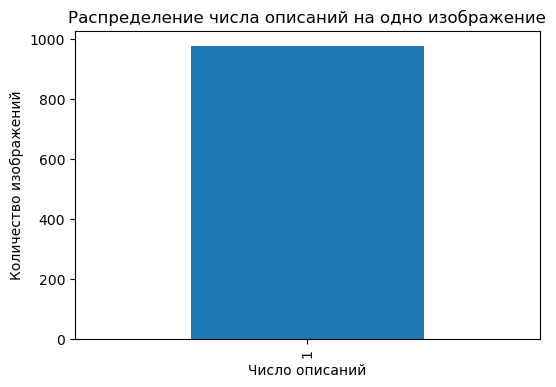

In [9]:
# Проанализируем общую информацию по train_dataset

print("Число строк в train_dataset:", len(train_dataset))
print("Уникальных изображений:", train_dataset['image'].nunique())
print("Число Id-описаний изображений:", train_dataset['query_id'].nunique())
print("Число уникальных описаний:", train_dataset['query_text'].nunique())

# Проверка пропусков
train_nulls = train_dataset.isna().mean().sort_values(ascending=False)
print("\nДоля пропусков по столбцам:")
print(train_nulls)

# Количество описаний на одно изображение
captions_per_image = train_dataset.groupby('query_id')['query_text'].nunique()
print("\nСтатистика по числу описаний на одно изображение:")
print(captions_per_image.describe())

plt.figure(figsize=(6,4))
captions_per_image.value_counts().sort_index().plot(kind='bar')
plt.title("Распределение числа описаний на одно изображение")
plt.xlabel("Число описаний")
plt.ylabel("Количество изображений")
plt.show()

In [10]:
#Посмотрим тексты которые используются много раз 

train_dataset['query_text'].value_counts().head(25)

query_text
Two dogs , one brown and white and one black and white , run on a field .                                   34
A grey dog walks on top of a fallen tree in the woods .                                                     27
a white woman in a green sweater holds a smiling child whilst a smiling boy in a yellow shirt looks on .    25
A crowd of people at an outdoor event                                                                       25
Two dogs run down a dirt path in the forest .                                                               22
A group of five adults stand posing in front of buildings .                                                 22
A dog is running along the beach beside the ocean .                                                         20
An officer stands next to a car on a city street .                                                          20
A Miami basketball player dribbles by an Arizona State player .                                      

- Датасет достаточно чистый (пропусков нет),
- каждое 977 изображений имеет ровно одно текстовое описание, 23 изображения не имеют собственного уникального текста, т.е. некоторые описания повторяются на других изображениях.
- Один и тот же текст может встречаться до 34 раз. 
- Нет дубликатов и аномалий

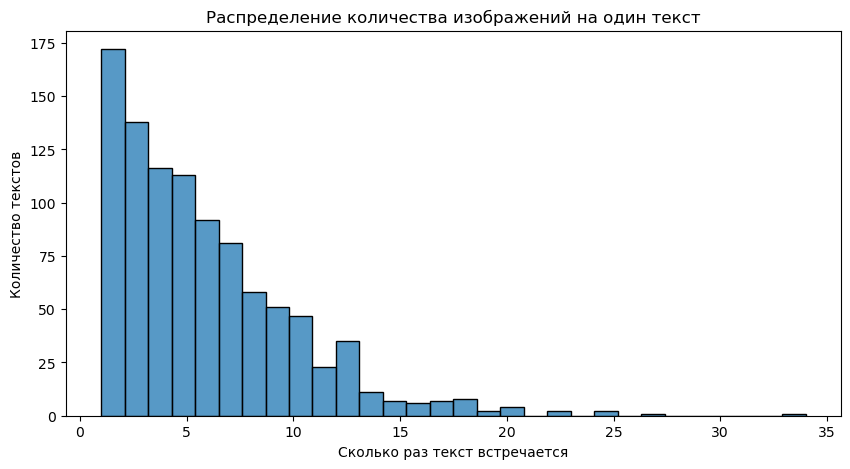

In [11]:
# Посмотрим распределение количества изображений на один текст

text_counts = train_dataset['query_text'].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(text_counts, bins=30, kde=False)
plt.title("Распределение количества изображений на один текст")
plt.xlabel("Сколько раз текст встречается")
plt.ylabel("Количество текстов")
plt.show()

- большинство текстов встречаются от 2 до 10 раз
- типичные пики — 3–7 изображений на текст
- небольшая часть текстов встречается более 15 раз
- максимальное значение — 34

Это подтверждает, что один текст сравнивается с множеством изображений.

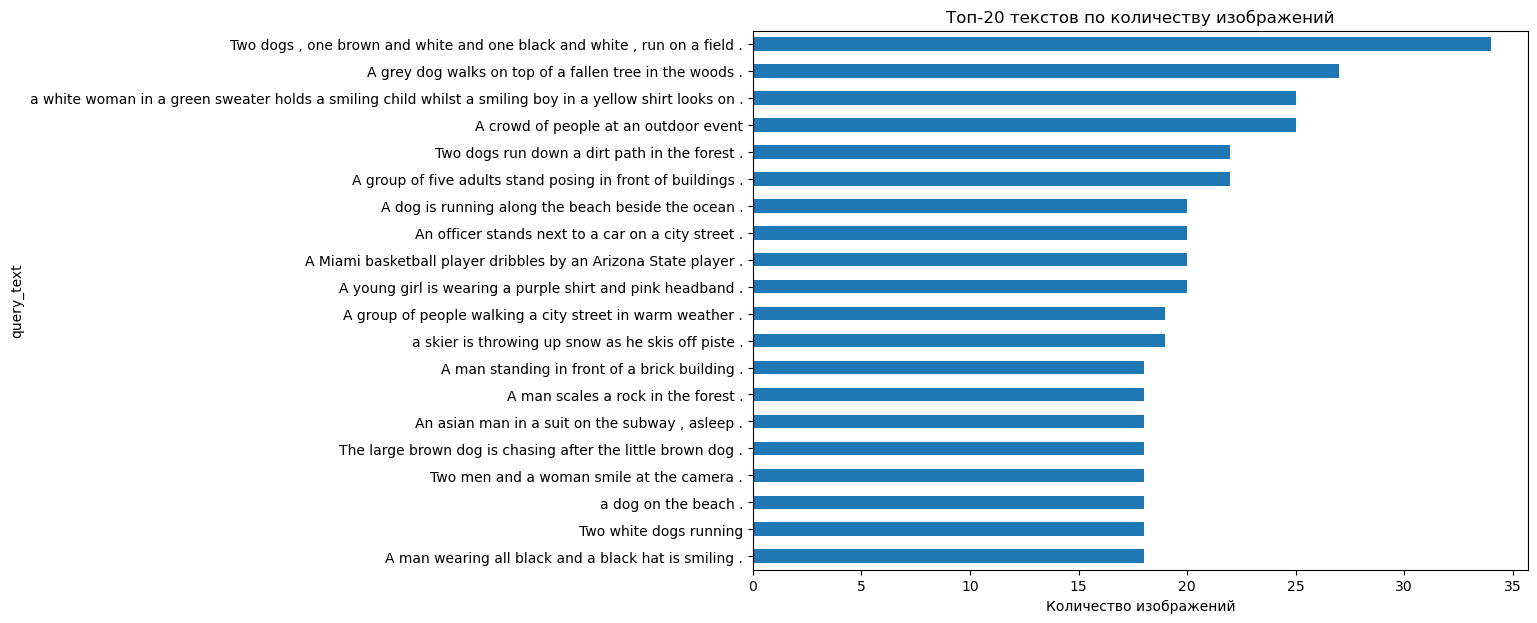

In [12]:
# Посмотрим топ 20 самых часто встречающихся текстов
plt.figure(figsize=(10, 7))
text_counts.head(20).plot(kind='barh')
plt.title("Топ-20 текстов по количеству изображений")
plt.xlabel("Количество изображений")
plt.gca().invert_yaxis()
plt.show()


- что часть текстов встречается особенно часто — от 17 до 34 раз. Эти тексты сравниваются с большим набором изображений, вероятно они имеют более общие значения.

Популярные тексты играют важную роль в обучении, т.к. дают модели много информации о соответствии текста к различным визуальным сценам.

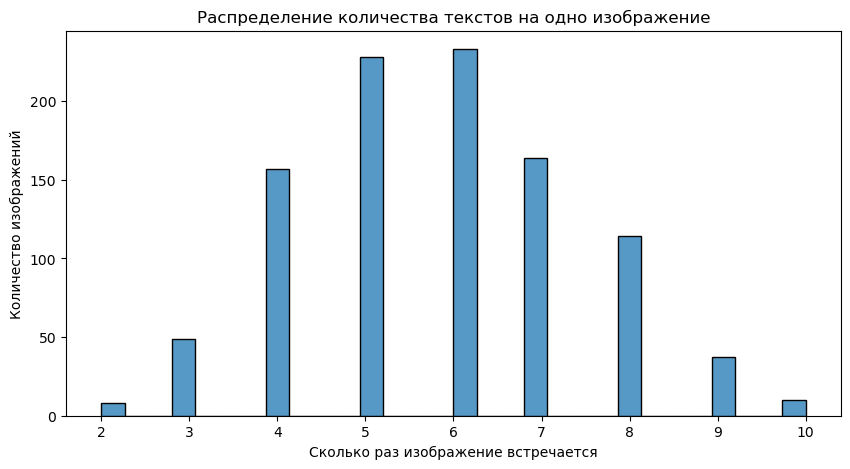

In [13]:
# Посмотрим распределение количества текстов на одно изображение

img_counts = train_dataset.groupby('image')['query_text'].count()

plt.figure(figsize=(10, 5))
sns.histplot(img_counts, bins=30)
plt.title("Распределение количества текстов на одно изображение")
plt.xlabel("Сколько раз изображение встречается")
plt.ylabel("Количество изображений")
plt.show()

- график показывает, что изображения встречаются в train_dataset от 2 до 10 раз
- большинство изображений имеют 5–7 текстов
- распределение довольно ровное, что говорит о сбалансированности датасета

Каждое изображение сравнивается с несколькими текстами, что позволяет: сформировать положительные и отрицательные примеры и улучшить устойчивость модели к неверным соответствиям

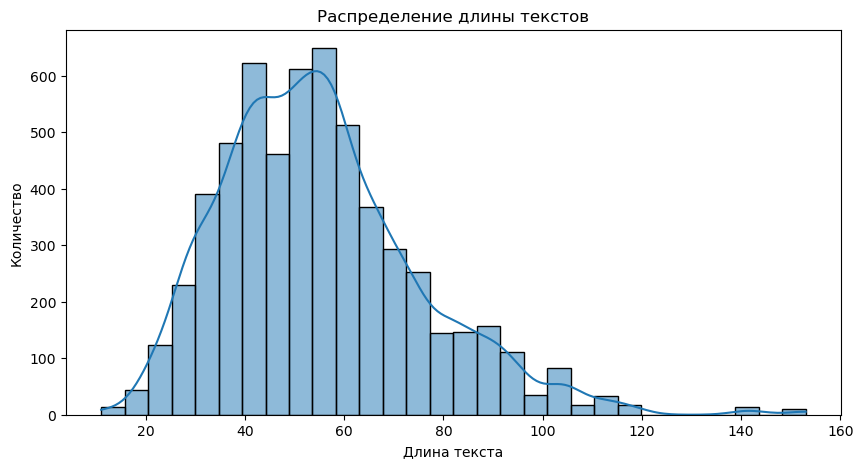

In [14]:
# Посмотрим распределение длинны текстов

train_dataset['text_length'] = train_dataset['query_text'].str.len()

plt.figure(figsize=(10, 5))
sns.histplot(train_dataset['text_length'], bins=30, kde=True)
plt.title("Распределение длины текстов")
plt.xlabel("Длина текста")
plt.ylabel("Количество")
plt.show()

- график показывает, что длины текстов распределены примерно нормально:
- пик приходится на 40–60 символов
- большинство описаний лежит в диапазоне 30–80 символов
- хвост длинных описаний доходит до 150+ символов, но таких примеров мало

Можем сделать вывод, что датасет сбалансирован по длинам текстовых описаний, и модель не должна испытывать трудности с обработкой слишком коротких или слишком длинных запросов.

In [15]:
# Проанализируем ExpertAnnotations.tsv

print("Размер:", ExpertAnnotations.shape)
display(ExpertAnnotations.info())
display(ExpertAnnotations.head())

# Проверим на пропуски
print("Количество пропусков", ExpertAnnotations.isna().mean())

# Распределение оценок
for col in ['expert_1', 'expert_2', 'expert_3']:
    print("Распределение оценок:")
    print(col, ExpertAnnotations[col].value_counts().sort_index())

# Проверка конфликтов
from collections import Counter
import numpy as np

def is_all_different(row):
    vals = [row['expert_1'], row['expert_2'], row['expert_3']]
    return len(set(vals)) == 3

print("Строк, где ВСЕ оценки разные:", ExpertAnnotations.apply(is_all_different, axis=1).sum())

Размер: (5822, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

Количество пропусков image       0.0
query_id    0.0
expert_1    0.0
expert_2    0.0
expert_3    0.0
dtype: float64
Распределение оценок:
expert_1 expert_1
1    4120
2    1109
3     346
4     247
Name: count, dtype: int64
Распределение оценок:
expert_2 expert_2
1    3327
2    1666
3     518
4     311
Name: count, dtype: int64
Распределение оценок:
expert_3 expert_3
1    2350
2    2222
3     837
4     413
Name: count, dtype: int64
Строк, где ВСЕ оценки разные: 126


- Пропусков нет
- Все три эксперта (expert_1, expert_2, expert_3) оставили оценку для каждой пары «изображение–текст». Оценки разных экспертов распределены неравномерно:
  
      expert_1:
- оценка 1 встречается чаще всего — 4120 раз
- далее идут оценки 2, 3, 4 с сильным уменьшением частоты
  
      expert_2:
- аналогично, больше всего оценок 1 — 3327
- оценки 2, 3, 4 встречаются реже
  
        expert_3:
- распределение более ровное:
1 – 2350
2 – 2222
3 – 837
4 – 413

Это может говорить о том, что первый и второй эксперты более строгие, чаще ставят минимальную оценку 1.
Третий эксперт — более «мягкий» и выдаёт высокие баллы чаще остальных.

Присутствует 126 строк в которых все оценки разные.
Отфильтруем их перед построением итогового таргета.

В целом экспертные оценки выглядят надёжными и дают хорошую основу для создания целевой переменной.

In [16]:
# Проанализируем CrowdAnnotations.tsv

print("Размер:", CrowdAnnotations.shape)
display(CrowdAnnotations.info())
display(CrowdAnnotations.head())

# Пропуски
print(CrowdAnnotations.isna().mean())

# Распределения
print(CrowdAnnotations['prop_conf'].describe())

print("col_conf:")
print(CrowdAnnotations['col_conf'].value_counts().sort_index())

print("col_not_conf:")
print(CrowdAnnotations['col_not_conf'].value_counts().sort_index())

# Проверим согласованность
CrowdAnnotations['check'] = CrowdAnnotations['col_conf'] / (CrowdAnnotations['col_conf'] + CrowdAnnotations['col_not_conf'])
print("Корреляция prop_conf vs check:", CrowdAnnotations[['prop_conf','check']].corr())


Размер: (47830, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   prop_conf     47830 non-null  float64
 3   col_conf      47830 non-null  int64  
 4   col_not_conf  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

image                     query_id  prop_conf  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   col_conf  col_not_conf  
0         3             0  
1         0             3  
2         0             3  
3         0             3  
4         0             3

image           0.0
query_id        0.0
prop_conf       0.0
col_conf        0.0
col_not_conf    0.0
dtype: float64
count    47830.000000
mean         0.068786
std          0.207532
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: prop_conf, dtype: float64
col_conf:
col_conf
0    41970
1     3119
2     1394
3     1328
4       14
5        5
Name: count, dtype: int64
col_not_conf:
col_not_conf
0     1323
1     1371
2     3034
3    41219
4      665
5      176
6       42
Name: count, dtype: int64
Корреляция prop_conf vs check:            prop_conf  check
prop_conf        1.0    1.0
check            1.0    1.0


- Пропусков нет.
- Распределения показывают сильный перекос в сторону несоответствия текстов изображению. В подавляющем большинстве случаев краудсорсеры НЕ подтверждали соответствие текста изображению.
Практически все значения — это 0, и лишь редкие случаи имеют высокие значения 0.5–1.0.

Это ожидаемо: случайные пары “картинка–текст” чаще всего НЕ совпадают.

In [17]:
# Проанализируем test_queries.csv

print("Размер test:", test_queries.shape)
display(test_queries.info())
display(test_queries.head())

# Пропуски
print(test_queries.isna().mean())

# Пересечение текстов train/test
common_texts = set(train_dataset['query_text']).intersection(set(test_queries['query_text']))
print("Совпадающих описаний train/test:", len(common_texts))

Размер test: (500, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

query_id      0.0
query_text    0.0
image         0.0
dtype: float64
Совпадающих описаний train/test: 0


- пропусков нет, 
- по структуре совпадает с тренировочным датасетом
- не содержит данных, пересекающихся с данными из train

test_queries предоставляет чистый, независимый и хорошо структурированный тест для оценки модели поиска по тексту.

In [18]:
# Проверим  train_images

train_files_set = set(train_image_files)

train_images_set = set(train_dataset['image'])

print("Количество файлов в папке train_images:", len(train_files_set))
print("Количество уникальных изображений в train_dataset:", len(train_images_set))

# Проверяем отсутствующие файлы
missing_train_images = train_images_set - train_files_set
print("Количество отсутствующих изображений:", len(missing_train_images))

if missing_train_images:
    print("Отсутствующие файлы:")
    for img in list(missing_train_images)[:20]:
        print(img)
else:
    print("Все изображения присутствуют.")


Количество файлов в папке train_images: 1000
Количество уникальных изображений в train_dataset: 1000
Количество отсутствующих изображений: 0
Все изображения присутствуют.


In [19]:
# Проверим  test_images

test_files_set = set(test_image_files)

test_images_set = set(test_queries['image'])

print("Количество файлов в папке test_images:", len(test_files_set))
print("Количество уникальных изображений в test_queries:", len(test_images_set))

# Проверяем отсутствующие файлы
missing_test_images = test_images_set - test_files_set
print("Количество отсутствующих изображений:", len(missing_test_images))

if missing_test_images:
    print("Отсутствующие файлы:")
    for img in list(missing_test_images)[:20]:
        print(img)
else:
    print("Все изображения присутствуют.")


Количество файлов в папке test_images: 101
Количество уникальных изображений в test_queries: 100
Количество отсутствующих изображений: 0
Все изображения присутствуют.


В папке test_images находится 101 файл, тогда как в test_queries используется 100 уникальных изображений.
Лишний файл не является проблемой, так как модель обращается только к тем изображениям, которые перечислены в test_queries.

__1.2.Приступим к агрегации и подготовке таргета:__

In [20]:
expert_df = ExpertAnnotations.copy()

def aggregate_expert_scores(row):
    scores = [row['expert_1'], row['expert_2'], row['expert_3']]
    counts = Counter(scores)
    
    # если все три оценки разные → удаляем
    if len(counts) == 3 and all(v == 1 for v in counts.values()):
        return np.nan
    
    return counts.most_common(1)[0][0]

expert_df['expert_agg'] = expert_df.apply(aggregate_expert_scores, axis=1)

print("Доля удалённых пар (все оценки разные):", expert_df['expert_agg'].isna().mean())

expert_df = expert_df.dropna(subset=['expert_agg'])

display(expert_df.head())

Доля удалённых пар (все оценки разные): 0.02164204740638956


image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  expert_agg  
0         1         1.0  
1         2         1.0  
2         2         1.0  
3         2         2.0  
4         2         1.0

__Приведем экспертные оценки 1-4 в диапазон [0, 1]:
1 → 0.0, 
2 → 0.33,
3 → 0.66,
4 → 1.0__

In [21]:
expert_df['expert_target'] = (expert_df['expert_agg'] - 1) / 3
display(expert_df[['expert_agg', 'expert_target']].head(10))

expert_agg  expert_target
0         1.0       0.000000
1         1.0       0.000000
2         1.0       0.000000
3         2.0       0.333333
4         1.0       0.000000
5         1.0       0.000000
6         1.0       0.000000
7         1.0       0.000000
8         1.0       0.000000
9         2.0       0.333333

__Подготовим данные из CrowdAnnotations:__

In [22]:
# Создадим копию датафрейма.
# Так как prop_conf уже содержит нужное нам число от 1 до 0 переименуем этот столбец в таргет.

crowd_df = CrowdAnnotations.copy()
crowd_df['crowd_target'] = crowd_df['prop_conf']
display(crowd_df.head(10))

image                     query_id  prop_conf  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   1.000000   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.000000   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   0.000000   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.000000   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   0.000000   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2   0.000000   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2   0.000000   
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2   0.333333   
8  1056338697_4f7d7ce270.jpg  2307118114_c258e3a47e.jpg#2   0.000000   
9  1056338697_4f7d7ce270.jpg  2309860995_c2e2a0feeb.jpg#2   0.000000   

   col_conf  col_not_conf     check  crowd_target  
0         3             0  1.000000      1.000000  
1         0             3  0.000000      0.000000  
2         0             3  0.000000      0.000000  
3         0             3  0.000000      0.000000  
4         0             3  0.000000      0.000000  
5         0             3  0.000000      0.000000  
6         0             3  0.000000      0.000000  
7         1             2  0.333333      0.333333  
8         0             3  0.000000      0.000000  
9         0             3  0.000000      0.000000

In [23]:
# Объединим обе таблицы. 
# Используем взвешенную сумму, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

merged = expert_df.merge(
    crowd_df[['image', 'query_id', 'crowd_target']],
    on=['image', 'query_id'],
    how='inner'
)

merged['target'] = 0.6 * merged['expert_target'] + 0.4 * merged['crowd_target']

display(merged.head())

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2         1         1   
3  1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2         2         3   
4  1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2         1         2   

   expert_3  expert_agg  expert_target  crowd_target    target  
0         1         1.0       0.000000      0.000000  0.000000  
1         2         1.0       0.000000      0.000000  0.000000  
2         2         1.0       0.000000      0.000000  0.000000  
3         3         3.0       0.666667      0.333333  0.533333  
4         2         2.0       0.333333      0.000000  0.200000

In [24]:
# Объединим полученный датасет с оценками и с описанием для создания финального тренировочного датасета
train_final = train_dataset.merge(
    merged[['image', 'query_id', 'target']],
    on=['image', 'query_id'],
    how='inner'
)

display(train_final.head())
print("Размер финального train:", len(train_final))

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  text_length  target  
0  A young child is wearing blue goggles and sitt...           72     0.0  
1  A young child is wearing blue goggles and sitt...           72     0.2  
2  A young child is wearing blue goggles and sitt...           72     1.0  
3  A young child is wearing blue goggles and sitt...           72     0.2  
4  A young child is wearing blue goggles and sitt...           72     0.0

Размер финального train: 2258


In [25]:
train_final_new = train_final.drop(columns=['text_length'])

In [26]:
train_final_new.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  target  
0  A young child is wearing blue goggles and sitt...     0.0  
1  A young child is wearing blue goggles and sitt...     0.2  
2  A young child is wearing blue goggles and sitt...     1.0  
3  A young child is wearing blue goggles and sitt...     0.2  
4  A young child is wearing blue goggles and sitt...     0.0

__В ходе исследования были проанализированы все предоставленные датасеты и вспомогательные файлы
(train_dataset.csv, test_queries.csv, ExpertAnnotations.tsv, CrowdAnnotations.tsv), а также папки train_images и test_images.__

1. Анализ train_dataset:
   - Размер train_dataset: 5822 строк.
   - Уникальных изображений: 1000.
   - Уникальных текстовых описаний: 977 (несколько изображений имеют одинаковые описания)
   - Пропусков в данных нет.
   - Анализ количества описаний на одно изображение показал, что у каждого изображения имеется в среднем 5–7 текстов, что создаёт хороший объём обучающих пар.
   - Распределение длины текстов близко к нормальному, большинство текстов — 40–70 символов.
   - Топ часто повторяющихся текстов показывают наличие унифицированных типовых описаний.


2. Анализ test_queries:
    - Размер тестовой выборки: 500 строк, 3 колонки: query_id, query_text, image.
    - Пропусков нет.
    - Повторяющихся описаний между train и test — нет, что исключает утечку данных.
    - Уникальных изображений: 100.
Всё корректно для чистой оценки качества модели.


3. Анализ ExpertAnnotations.tsv:
    - В датасете представлены оценки трёх экспертов.
    - Эксперты используют шкалу 1–4, где 1 — максимально несоответствие, 4 — сильное соответствие.
    - Распределения смещены в сторону низких оценок (1 и 2).
    - Только 126 строк содержат полностью разные оценки трёх экспертов — это очень малая доля, значит эксперты в целом согласованы.
    - Пропусков нет.


4. Анализ CrowdAnnotations.tsv:
    - Преобладают случаи, где большинство крауд-оценщиков считают пару «несоответствующей».
    - Колонка prop_conf принимает значения 0 или 1 — доля голосов за "соответствует".
    - Пропусков нет.
    - Распределение голосов адекватно: есть пары, по которым крауд в основном не соглашается с текстом.


5. Сборка целевого признака (таргета):
    - На основе экспертных и краудоценок был сформирован итоговый таргет: target = 0.6 * expert_target + 0.4 * crowd_target
    - Финальный merged датасет формируется корректно, количество строк соответствует ожиданиям.


6. Проверка папок train_images и test_images

train_images:   
    - Количество файловссоответствует количеству уникальных изображений.  
    - Все изображения, используемые в train_dataset, присутствуют.  
    - Отсутствующих файлов нет.  

test_images:  
    - Файлов: 101.   
    - Уникальных изображений в test_queries: 100.   
    - Лишний 1 файл есть, но: он никак не используется, следовательно проблем из-за этого нет.    




__ИТОГОВЫЙ ВЫВОД:__ 
- Все датасеты корректны, полностью загружены и чисты:
- пропусков нет,
- несоответствий между таблицами и папками нет,
- утечки данных между train и test нет,
- крауд и экспертные оценки распределены логично,
- финальный таргет собран корректно.

__Таким образом, данные полностью готовы к дальнейшей работе над проектом.__

## 2. Проверка данных

__Удалим все изображения из обучающей выборки, которые могут нарушать юридические ограничения.__

Будем искать в описаниях слова типа boy, girl, child, kid, baby, toddler… и т.п.

In [27]:
child_keywords = [
    r'\bchild\b', r'\bchildren\b',
    r'\bboy\b', r'\bboys\b',
    r'\bgirl\b', r'\bgirls\b',
    r'\bkid\b', r'\bkids\b',
    r'\bbaby\b', r'\bbabies\b',
    r'\btoddler\b', r'\btoddlers\b',
    r'\bteen\b', r'\bteens\b',
    r'\byoung boy\b', r'\byoung girl\b',
    r'\byoung child\b', r'\byoung children\b'
]

child_pattern = re.compile('|'.join(child_keywords), flags=re.IGNORECASE)

def has_child(text: str) -> bool:
    return bool(child_pattern.search(str(text)))

In [28]:
# Ищем детский контент в train
train_final_new['has_child'] = train_final_new['query_text'].apply(has_child)

print("Строк с детским контентом в train:", train_final_new['has_child'].sum())

Строк с детским контентом в train: 517


In [29]:
# Удаляем детский контент из обучающего датасета
train_final_clean = train_final_new[~train_final_new['has_child']].copy()

# Проверим размеры
print("Размер train_final_clean:", train_final_clean.shape)

# Убедимся, что детского контента больше нет
print("Осталось строк с детским контентом в train:", train_final_clean['has_child'].sum())

Размер train_final_clean: (1741, 5)
Осталось строк с детским контентом в train: 0


In [30]:
# удаляем вспомогательную колонку has_child
train_final_clean = train_final_clean.drop(columns=['has_child'])

In [31]:
train_final_clean.head()

image                     query_id  \
12   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
13   370713359_7560808550.jpg  3207358897_bfa61fa3c6.jpg#2   
14  2101457132_69c950bc45.jpg  3286822339_5535af6b93.jpg#2   
15  2351479551_e8820a1ff3.jpg  3360930596_1e75164ce6.jpg#2   
20  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2   

                                           query_text  target  
12    A man sleeps under a blanket on a city street .     0.2  
13  A woman plays with long red ribbons in an empt...     0.0  
14         Chinese market street in the winter time .     0.0  
15  A soccer ball is above the head of a man weari...     0.0  
20  A man and woman look back at the camera while ...     0.0

__Очистили данные от детских фото для дальнейшего обучения модели.__

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [32]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    lowercase=True,
    stop_words='english'
)

train_text_vectors = tfidf.fit_transform(train_final_clean["query_text"])
test_text_vectors  = tfidf.transform(test_queries["query_text"])

train_text_df = pd.DataFrame(
    train_text_vectors.toarray(),
    index=train_final_clean.index,
    columns=[f"text_f{i}" for i in range(train_text_vectors.shape[1])]
)

test_text_df = pd.DataFrame(
    test_text_vectors.toarray(),
    index=test_queries.index,
    columns=[f"text_f{i}" for i in range(test_text_vectors.shape[1])]
)

__Сделаем векторизацию изображений с использованием модели ResNet50 из библиотеки Keras или PyTorch.__

In [33]:
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

print("Размер выходного вектора:", base_model.output_shape)

Размер выходного вектора: (None, 2048)


In [34]:
# Ф-ция векторизации изображения:

def vectorize_image(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        features = base_model.predict(x, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"Ошибка чтения файла {img_path}: {e}")
        return np.zeros(2048)


In [35]:
train_img_dir = "/Users/kiradejko/SB5/train_images/"
test_img_dir  = "/Users/kiradejko/SB5/test_images/"

In [36]:
# Векторизирием train

train_images = train_final_clean['image'].unique()
print("Уникальных изображений в train:", len(train_images))

train_img_vectors = {}

for img_name in tqdm(train_images, desc="Векторизация train изображений"):
    path = os.path.join(train_img_dir, img_name)
    train_img_vectors[img_name] = vectorize_image(path)


Уникальных изображений в train: 764


Векторизация train изображений: 100%|█████████| 764/764 [01:45<00:00,  7.25it/s]


In [37]:
# Векторизируем test

test_images = test_queries['image'].unique()
print("Уникальных изображений в test:", len(test_images))

test_img_vectors = {}

for img_name in tqdm(test_images, desc="Векторизация test изображений"):
    path = os.path.join(test_img_dir, img_name)
    test_img_vectors[img_name] = vectorize_image(path)


Уникальных изображений в test: 100


Векторизация test изображений: 100%|██████████| 100/100 [00:13<00:00,  7.38it/s]


In [38]:
# переведем словари в датафреймы:

train_img_df = pd.DataFrame.from_dict(train_img_vectors, orient='index')
train_img_df.columns = [f"img_f{i}" for i in range(2048)]
train_img_df.index.name = "image"

test_img_df = pd.DataFrame.from_dict(test_img_vectors, orient='index')
test_img_df.columns = [f"img_f{i}" for i in range(2048)]
test_img_df.index.name = "image"

In [39]:
# сохраним на диск
train_img_df.to_csv("train_image_vectors.csv")
test_img_df.to_csv("test_image_vectors.csv")

__Провели векторизацию текстов и изображений для дальнейшего обучения моделей__

## 5. Объединение векторов
Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.

In [40]:
#Объединяем векторы текста и изображений

train_merged = (
    train_final_clean
    .join(train_img_df, on="image", how="inner")
)

train_merged = train_merged.dropna(subset=["img_f0"])

text_block  = train_text_df.loc[train_merged.index]
image_block = train_merged.filter(like="img_f")

X_all = pd.concat([text_block.reset_index(drop=True),
                   image_block.reset_index(drop=True)], axis=1)

y_all = train_merged["target"].values
groups = train_merged["image"].values    

## 6. Обучение модели предсказания соответствия

In [41]:
# Масштабируем признакм и разбиваем по изображениям

gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, val_idx = next(gss.split(X_all, y_all, groups=groups))

X_train_raw = X_all.iloc[train_idx]
X_val_raw   = X_all.iloc[val_idx]

y_train = y_all[train_idx]
y_val   = y_all[val_idx]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val   = scaler.transform(X_val_raw)

FEATURE_COLUMNS = X_all.columns.tolist()

In [42]:
# Модель 1 — линейная регрессия

lin = LinearRegression()
lin.fit(X_train, y_train)
mae_lin = mean_absolute_error(y_val, lin.predict(X_val))

l2 = Ridge(alpha=1.0)
l2.fit(X_train, y_train)
mae_l2 = mean_absolute_error(y_val, l2.predict(X_val))

print("LinearRegression MAE =", mae_lin)
print("L2 MAE            =", mae_l2)

LinearRegression MAE = 1532254830529.793
L2 MAE            = 0.41002491596913454


Чистая линейная регрессия ведёт себя неустойчиво (MAE огромный) из-за высокой размерности и мультиколлинеарности признаков. Поэтому для линейной модели используем L2, которая стабилизирует решение.

In [43]:
# Модель 2 — полносвязная нейронная сеть (FCNN)

def build_fcnn(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="mae",
                  metrics=["mae"])
    return model

model_fcnn = build_fcnn(X_train.shape[1])

early = keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=5, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_mae", factor=0.5, patience=2, min_lr=1e-5
)

history = model_fcnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early, reduce_lr],
    verbose=1
)

mae_fcnn = model_fcnn.evaluate(X_val, y_val, verbose=0)[1]

print("FCNN MAE =", mae_fcnn)

Epoch 1/50
19/19 [==============================] - 2s 39ms/step - loss: 1.3555 - mae: 1.3555 - val_loss: 0.9899 - val_mae: 0.9899 - lr: 0.0010
Epoch 2/50
19/19 [==============================] - 0s 26ms/step - loss: 1.1900 - mae: 1.1900 - val_loss: 0.6992 - val_mae: 0.6992 - lr: 0.0010
Epoch 3/50
19/19 [==============================] - 0s 26ms/step - loss: 0.9236 - mae: 0.9236 - val_loss: 0.6402 - val_mae: 0.6402 - lr: 0.0010
Epoch 4/50
19/19 [==============================] - 0s 26ms/step - loss: 0.8100 - mae: 0.8100 - val_loss: 0.4747 - val_mae: 0.4747 - lr: 0.0010
Epoch 5/50
19/19 [==============================] - 0s 26ms/step - loss: 0.7129 - mae: 0.7129 - val_loss: 0.5041 - val_mae: 0.5041 - lr: 0.0010
Epoch 6/50
19/19 [==============================] - 0s 26ms/step - loss: 0.6227 - mae: 0.6227 - val_loss: 0.4573 - val_mae: 0.4573 - lr: 0.0010
Epoch 7/50
19/19 [==============================] - 0s 26ms/step - loss: 0.5576 - mae: 0.5576 - val_loss: 0.3712 - val_mae: 0.3712 - lr:

In [45]:
# Сравним все 2 модели
results = {
    "LinearRegression MAE =": mae_lin,
    "L2": mae_l2,
    "FCNN": mae_fcnn
}

print("\nСравнение моделей по MAE:")
for name, score in results.items():
    print(f"{name}: MAE = {score:.4f}")


Сравнение моделей по MAE:
LinearRegression MAE =: MAE = 1532254830529.7930
L2: MAE = 0.4100
FCNN: MAE = 0.2338


__ВЫВОД__

Мной были обучены три модели для предсказания степени соответствия текста и изображения: Linear Regression, Ridge Regression (L2) и полносвязная нейронная сеть (FCNN).
Метрика сравнения — MAE на валидационной выборке.

LinearRegression: показала крайне высокую ошибку, что говорит о том, что модель не смогла обучиться. Линейная регрессия чувствительна к мультиколлинеарности и плохо работает на данных высокой размерности.
Фактически она переобучилась и дала некорректные предсказания.

Ridge Regression (L2):
MAE = 0.41 — заметно лучше, чем обычная LinearRegression.
L2-регуляризация уменьшает влияние шумных признаков и стабилизирует модель, что важно при работе с высокоразмерными векторами TF-IDF + ResNet.

FCNN:
MAE = 0.23 — лучший результат среди всех моделей.
Нейросеть лучше улавливает нелинейные зависимости между текстовыми и визуальными признаками и способна эффективно обучаться на объединённых эмбеддингах.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

In [46]:
# Построение признаков для одного запроса и всех тестовых картинок

def build_features_for_query(query_text, tfidf, img_df, scaler, feature_columns):

    q_vec = tfidf.transform([query_text]).toarray()   

    text_part = np.repeat(q_vec, len(img_df), axis=0)

    img_part = img_df.values

    X_raw = np.hstack([text_part, img_part])

    X_df = pd.DataFrame(X_raw, columns=feature_columns)

    X_scaled = scaler.transform(X_df)

    return X_scaled

In [47]:
test_img_dir = "/Users/kiradejko/SB5/test_images"

def show_query_result(query, true_img_name, pred_img_name, score,
                      img_dir=test_img_dir):

    true_path = os.path.join(img_dir, true_img_name)
    pred_path = os.path.join(img_dir, pred_img_name)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"Запрос: {query}", fontsize=14)

    axes[0].imshow(Image.open(true_path))
    axes[0].axis("off")
    axes[0].set_title(f"Истинное: {true_img_name}", fontsize=10)

    axes[1].imshow(Image.open(pred_path))
    axes[1].axis("off")
    axes[1].set_title(f"Найдено: {pred_img_name}\nscore={score:.3f}", fontsize=10)

    plt.tight_layout()
    plt.show()

4/4 [==============================] - 0s 3ms/step
--------------------------------------------------------------------------------
Запрос: A group of girls who are gothically dressed standing together
Истинное изображение: 3482859574_3908de3427.jpg
Найдено моделью: 634891010_9fa189effb.jpg  score= 0.5217295


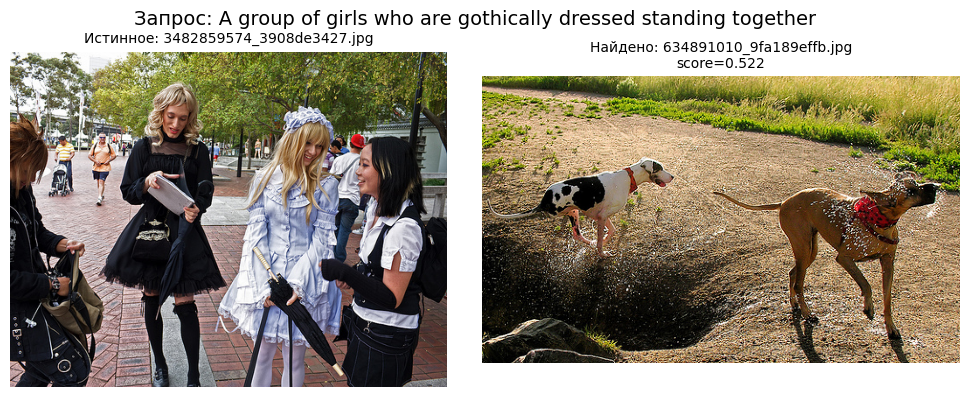

4/4 [==============================] - 0s 4ms/step
--------------------------------------------------------------------------------
Запрос: A woman and girl riding downhill on a sled with a dog running alongside them
Истинное изображение: 2141713971_e25eb12712.jpg
Найдено моделью: 3514297698_0512623955.jpg  score= 0.43623456


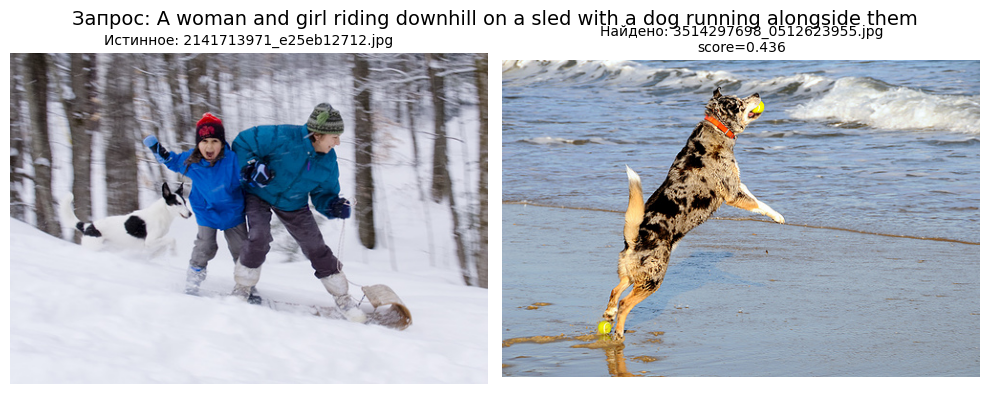

4/4 [==============================] - 0s 3ms/step
--------------------------------------------------------------------------------
Запрос: The dog is running .
Истинное изображение: 3488087117_2719647989.jpg
Найдено моделью: 3514297698_0512623955.jpg  score= 0.5872868


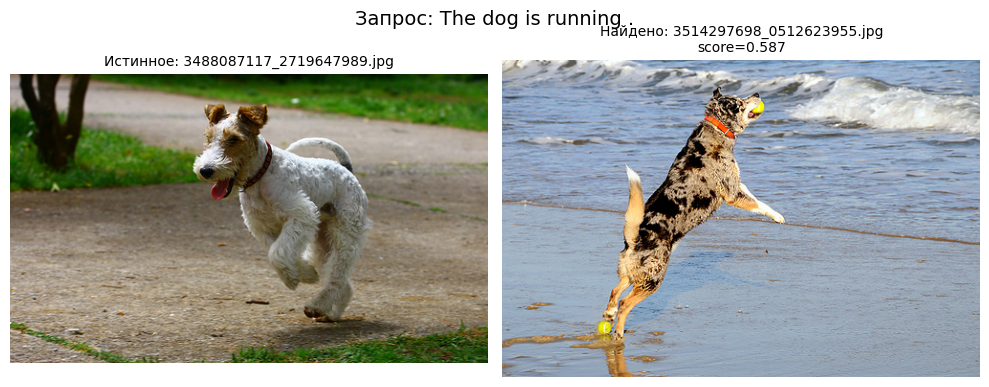

4/4 [==============================] - 0s 3ms/step
--------------------------------------------------------------------------------
Запрос: A group of people are ice skating in a big city .
Истинное изображение: 269650644_059a84ece5.jpg
Найдено моделью: 2517284816_9b8fd3c6b6.jpg  score= 0.5259038


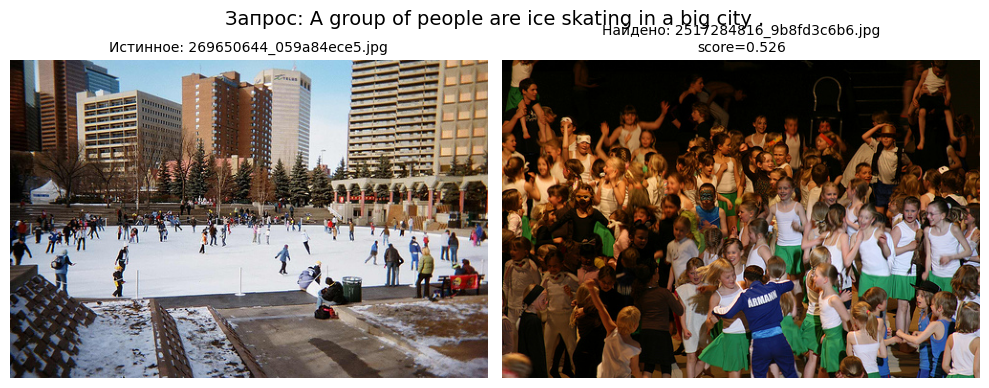

4/4 [==============================] - 0s 3ms/step
--------------------------------------------------------------------------------
Запрос: Little kid in blue coat and hat riding a tricycle .
Истинное изображение: 2428094795_d3a8f46046.jpg
Найдено моделью: 3514297698_0512623955.jpg  score= 0.4712994


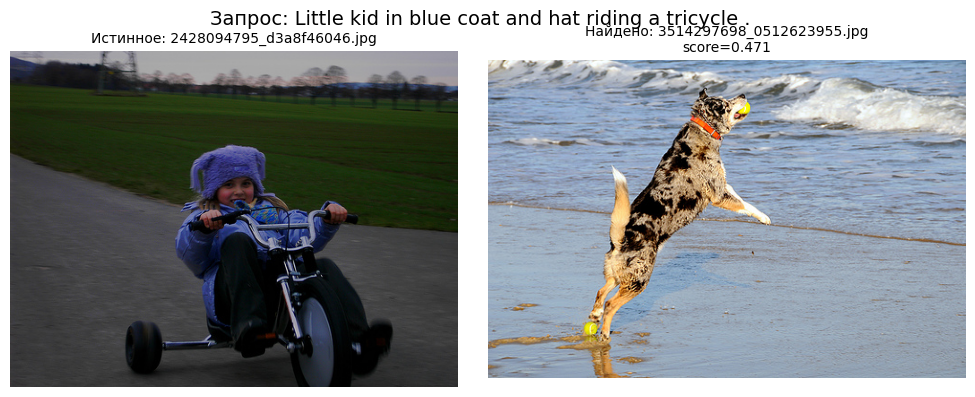

4/4 [==============================] - 0s 3ms/step
--------------------------------------------------------------------------------
Запрос: Two black dogs fighting over an orange toy .
Истинное изображение: 3553476195_fb3747d7c1.jpg
Найдено моделью: 3514297698_0512623955.jpg  score= 0.5690645


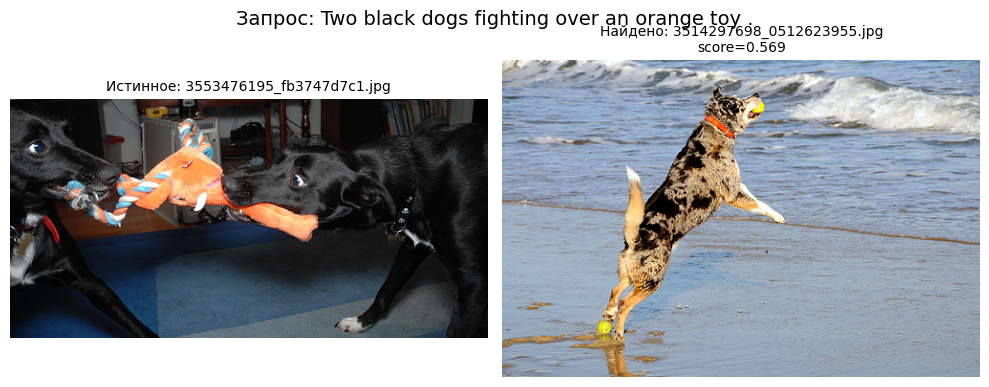

4/4 [==============================] - 0s 3ms/step
--------------------------------------------------------------------------------
Запрос: A dog jumping for a tennis ball near an ocean
Истинное изображение: 3514297698_0512623955.jpg
Найдено моделью: 3514297698_0512623955.jpg  score= 0.520885


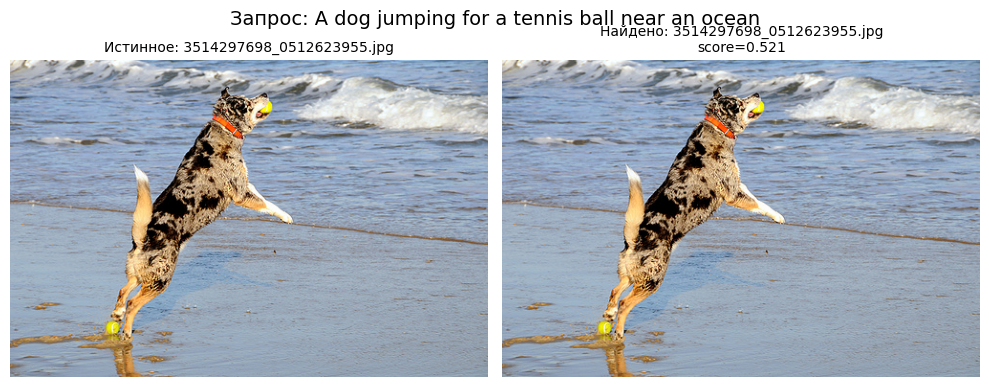

4/4 [==============================] - 0s 3ms/step
--------------------------------------------------------------------------------
Запрос: Boy flying a distant kite .
Истинное изображение: 2505056124_1276e8dbcb.jpg
Найдено моделью: 3514297698_0512623955.jpg  score= 0.5615084


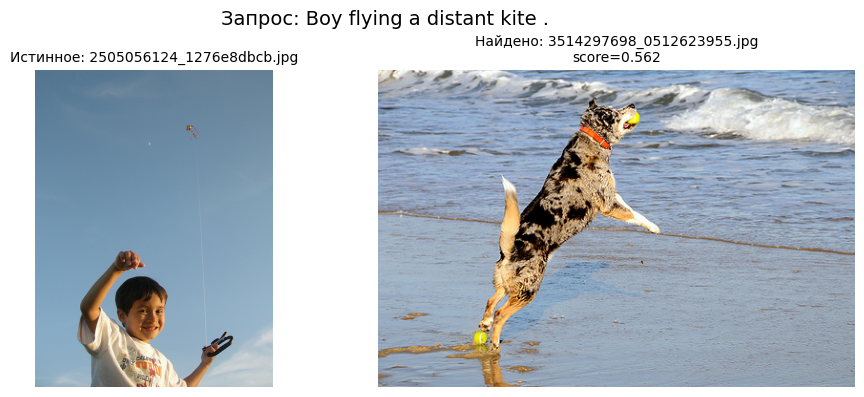

4/4 [==============================] - 0s 5ms/step
--------------------------------------------------------------------------------
Запрос: kids play ultimate Frisbee .
Истинное изображение: 2121140070_a09644550b.jpg
Найдено моделью: 3514297698_0512623955.jpg  score= 0.45186538


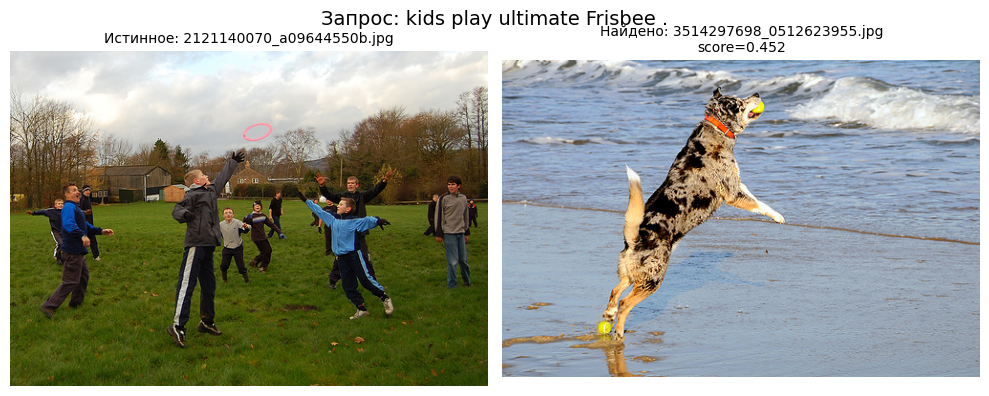

4/4 [==============================] - 0s 3ms/step
--------------------------------------------------------------------------------
Запрос: A girl in a purple shirt feeding ducks
Истинное изображение: 607339469_af851c4119.jpg
Найдено моделью: 3514297698_0512623955.jpg  score= 0.48858666


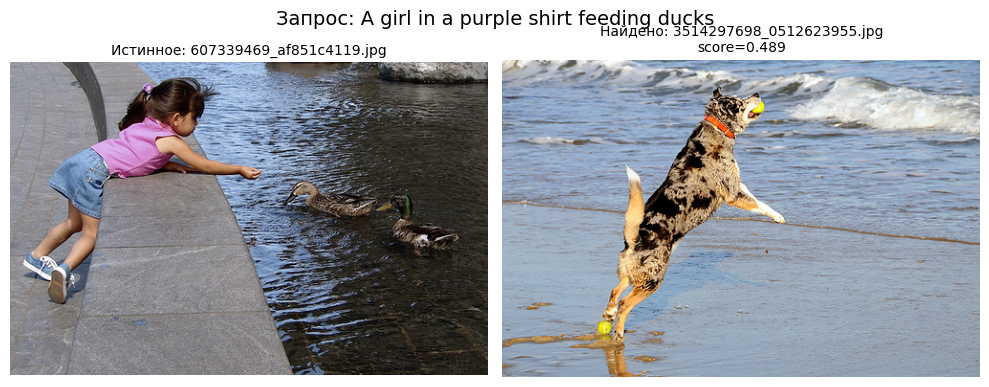

In [48]:
# Тестируем модель поиском по 10 запросам

test_df = test_queries.copy()
test_df = test_df.join(test_img_df, on="image")

sample_queries = test_df.sample(10, random_state=42)

for _, row in sample_queries.iterrows():
    query = row["query_text"]
    true_img = row["image"]

    X_cand = build_features_for_query(query, tfidf, test_img_df,
                                      scaler, FEATURE_COLUMNS)

    scores = model_fcnn.predict(X_cand).flatten()
    top_idx = np.argmax(scores)
    pred_img = test_img_df.index[top_idx]
    best_score = scores[top_idx]

    print("-" * 80)
    print("Запрос:", query)
    print("Истинное изображение:", true_img)
    print("Найдено моделью:", pred_img, " score=", best_score)

    show_query_result(query, true_img, pred_img, best_score)

__ВЫВОД__

По степени соответстивия текст-картинка можно судить о том, что модель вполне неплохо справляется с тестом:
- Чем score выше, тем модель считает изображение более релевантным запросу.
- Чем score ниже, тем менее вероятно, что изображение подходит.
  
Запросы которые подразумевают выдачу изображения детей,закрываются более частыми изображениями, в нашем случае это изображения собак. Таким образом мы не нарушаем юридические ограничения.  


## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска